In [6]:
import tempfile
import pickle as pkl
from pathlib import Path
import os
import yaml

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

import mlflow

from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import GPT2Tokenizer

import shap

from auxiliar import crear_ensemble_donadas

In [7]:
# Paramètres
with open("config.yml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

INPUT_FICHIER_WIKI_TEXTE = config["camins"]["texte"]["fichier_wiki_texte"]

INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_aleatori"]
INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_automatic"]
INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_entropia"]

INPUT_DOSSIER_TOKENIZAIRE = config["camins"]["tokenizaire"]["dossier_tokenizaire"]

OUTPUT_PREDICCIONS = config["camins"]["classificador"]["xgboost"]["prediccions"]
OUTPUT_SELECCION_PAGINAS = config["camins"]["classificador"]["xgboost"]["seleccion_paginas"]
OUTPUT_DOSSIER_MODEL = config["camins"]["classificador"]["xgboost"]["dossier_model"]

MIN_LEN = int(config["parametres"]["longor_min"])
MAX_LEN = config["parametres"]["longor_max"]
if MAX_LEN == "inf":
    MAX_LEN = np.inf

OPTIMIZACION_BAYESIANA = False

In [8]:
texte_df = pd.read_csv(INPUT_FICHIER_WIKI_TEXTE)
longor_texte = texte_df["Texte"].apply(len)
texte_df = texte_df[(longor_texte > MIN_LEN) & (longor_texte < MAX_LEN)].reset_index(drop=True)

texte_etiquetas_df = crear_ensemble_donadas(
    texte_df=texte_df,
    lista_dialectes_df=[
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI),
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC),
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA),
    ],
)
texte_etiquetas_df

,Article,Dialecte,Texte
0,Vieux-Champagne,lengadocian,vieux-champagne es una situada dins lo de sèin...
1,Ereditat,lengadocian,lereditat (del latin hereditas çò que s'erita ...
2,White_Town,lengadocian,white town es un projècte britanic de musica e...
3,Puigverd_d'Agramunt,lengadocian,puigverd d'agramunt es un de la
4,La_Grande_Montagne,lengadocian,la grande montagne es una de sant bartomieu di...
...,...,...,...
8289,Roger_de_Flor,provençal,ruggero da fiore ò rutger von blum (vèrs 1267 ...
8290,Aurelian_(emperaire_roman),provençal,aurelian en latin: lucius domitius aurelianus ...
8291,Miranda_(Gers),gascon,miranda (mirande en ) qu'ei ua ancianas ?
8292,Lekunberri_(Baisha_Navarra),gascon,lekunberri (


In [9]:
texte_etiquetas_entrenament, texte_etiquetas_test = train_test_split(texte_etiquetas_df, test_size=0.2)

In [10]:
# Crear sac a mots
tokenizaire = GPT2Tokenizer.from_pretrained(
    INPUT_DOSSIER_TOKENIZAIRE,
    do_lower_case=True,
)
tokens_entrenament = texte_etiquetas_entrenament["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_test = texte_etiquetas_test["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_tot = texte_df["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))

vectorizador = CountVectorizer()
bow_entrenament = vectorizador.fit_transform(tokens_entrenament)
bow_test = vectorizador.transform(tokens_test)
bow_tot = vectorizador.transform(tokens_tot)

# Codificar los dialèctes
codificador_ordinal = OrdinalEncoder()
etiquetas_entrenament = codificador_ordinal.fit_transform(texte_etiquetas_entrenament[["Dialecte"]]).astype(int)
etiquetas_test = codificador_ordinal.transform(texte_etiquetas_test[["Dialecte"]]).astype(int)

In [11]:
melhor_params = {}
if OPTIMIZACION_BAYESIANA:

    def evaluar(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
        kf = KFold(n_splits=3)
        f1_scores = []

        for train_index, valid_index in kf.split(bow_entrenament):

            xgb = XGBClassifier(
                max_depth=int(max_depth),
                learning_rate=learning_rate,
                n_estimators=int(n_estimators),
                gamma=gamma,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
            )
            xgb.fit(
                bow_entrenament[train_index],
                etiquetas_entrenament[train_index],
                sample_weight=compute_sample_weight("balanced", etiquetas_entrenament[train_index]),
                verbose=False,
            )
            etiquetas_predichas = xgb.predict(bow_entrenament[valid_index])
            score = f1_score(etiquetas_entrenament[valid_index], etiquetas_predichas, average="macro")
            f1_scores.append(score)

        return np.mean(f1_scores)

    limits = {
        "max_depth": (3, 12),
        "learning_rate": (0.01, 0.5),
        "n_estimators": (50, 200),
        "gamma": (0, 0.5),
        "min_child_weight": (1, 10),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
    }

    optimizaire = BayesianOptimization(f=evaluar, pbounds=limits, random_state=63, verbose=2)

    optimizaire.maximize(init_points=10, n_iter=20)

    melhor_params = optimizaire.max["params"]
    melhor_params["max_depth"] = int(melhor_params["max_depth"])
    melhor_params["n_estimators"] = int(melhor_params["n_estimators"])

2024/07/11 18:41:34 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost' does not exist. Creating a new experiment.


Exactitud: 0.9336949969861362
Precision: 0.7692052643989246
Rappel: 0.8027503233470443
F1: 0.7790432428724315


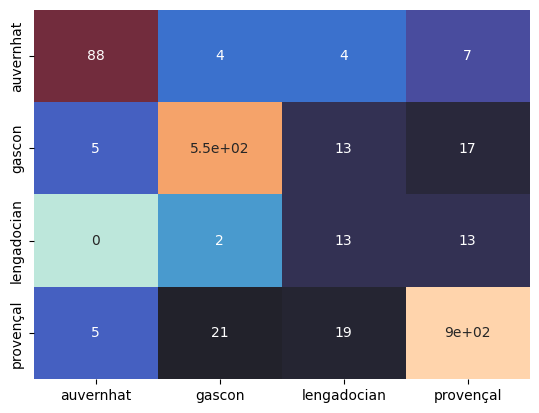

In [12]:
# Initialize MLflow
mlflow.set_experiment("XGBoost")
os.makedirs("mlruns", exist_ok=True)

# Start an MLflow run
with mlflow.start_run():

    # Entrenar e gardar lo darrièr model
    xgb_final = XGBClassifier(**melhor_params)

    xgb_final.fit(
        bow_entrenament,
        etiquetas_entrenament,
        sample_weight=compute_sample_weight("balanced", etiquetas_entrenament),
    )
    for nom_param, valor_param in melhor_params.items():
        mlflow.log_param(nom_param, valor_param)

    # Predire e evaluar lo model
    y_pred_test = xgb_final.predict(bow_test).reshape(-1, 1)

    # Transformar las etiquetas numericas en etiquetas textualas
    dialecte_obs_test = codificador_ordinal.inverse_transform(etiquetas_test)
    dialecte_pred_test = codificador_ordinal.inverse_transform(y_pred_test)

    # Exactitud, Precision, Rappel, F1
    exactitud = accuracy_score(dialecte_obs_test, dialecte_pred_test)
    precision, rappel, f1, _ = precision_recall_fscore_support(
        dialecte_obs_test,
        dialecte_pred_test,
        average="macro",
    )
    print(f"Exactitud: {exactitud}\nPrecision: {precision}\nRappel: {rappel}\nF1: {f1}")
    mlflow.log_metric("exactitud", exactitud)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("rappel", rappel)
    mlflow.log_metric("f1", f1)

    # Matritz de confusion
    matritz_confusion = confusion_matrix(dialecte_obs_test, dialecte_pred_test)
    matritz_confusion_df = pd.DataFrame(
        matritz_confusion,
        index=codificador_ordinal.categories_[0],
        columns=codificador_ordinal.categories_[0],
    )
    fig = sns.heatmap(np.log(matritz_confusion_df + 1), annot=matritz_confusion_df, cbar=None, cmap="icefire")
    with tempfile.NamedTemporaryFile(suffix=".png") as temp_file:
        plt.savefig(temp_file.name)
        mlflow.log_artifact(temp_file.name, artifact_path="images")

In [13]:
with open(Path(OUTPUT_DOSSIER_MODEL) / Path("vectorizador.pkl"), "wb") as f:
    pkl.dump(vectorizador, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("codificador_ordinal.pkl"), "wb") as f:
    pkl.dump(codificador_ordinal, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("classificador.pkl"), "wb") as f:
    pkl.dump(xgb_final, f)

In [14]:
# Generar prediccions per totes los articles
y_pred_tot = xgb_final.predict(bow_tot).reshape(-1, 1)
y_prob_tot = xgb_final.predict_proba(bow_tot)
entropia_tot = np.sum(-y_prob_tot * np.log(y_prob_tot), axis=1)
resultats_df = pd.DataFrame(
    {
        "Article": texte_df["Article"],
        "Prediccion": codificador_ordinal.inverse_transform(y_pred_tot).reshape(-1),
        "Entropia": entropia_tot.reshape(-1),
    }
)
resultats_df = pd.concat(
    [resultats_df, pd.DataFrame(y_prob_tot, columns=codificador_ordinal.categories_[0])],
    axis=1,
)
resultats_df = resultats_df.merge(texte_etiquetas_df[["Article", "Dialecte"]], on="Article", how="left")
resultats_df.to_csv(OUTPUT_PREDICCIONS, index=False)
resultats_df.sort_values("Entropia", ascending=False)["Article"].to_csv(
    OUTPUT_SELECCION_PAGINAS, index=False, header=False
)
resultats_df.sort_values("Entropia", ascending=False)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
29431,Stix,provençal,1.384695,2.415236e-01,2.410314e-01,2.427183e-01,2.747267e-01,NaN
4754,Saint-Martin-sur-Nohain,gascon,1.382924,2.160543e-01,2.658966e-01,2.530648e-01,2.649842e-01,NaN
72540,Colador,lengadocian,1.380762,2.345367e-01,2.269255e-01,2.951742e-01,2.433637e-01,NaN
80635,Gruffy,gascon,1.380288,2.618748e-01,2.717948e-01,2.622824e-01,2.040479e-01,NaN
48366,La_Comunautat_de_l'Anèl,lengadocian,1.378952,2.284486e-01,2.454631e-01,3.016125e-01,2.244758e-01,NaN
...,...,...,...,...,...,...,...,...
14997,La_Celestina,gascon,0.000038,8.641970e-08,9.999974e-01,3.688054e-07,2.210365e-06,NaN
11473,Guelfs_e_Gibelins,provençal,0.000027,4.654101e-07,9.016361e-07,3.719512e-07,9.999982e-01,provençal
30331,Guèrras_Arabobizantinas,provençal,0.000026,2.078848e-07,1.046915e-06,4.834061e-07,9.999982e-01,provençal
53346,Neuròna,gascon,0.000023,4.445255e-07,9.999986e-01,6.620120e-07,3.651521e-07,gascon


<Axes: xlabel='Prediccion', ylabel='Entropia'>

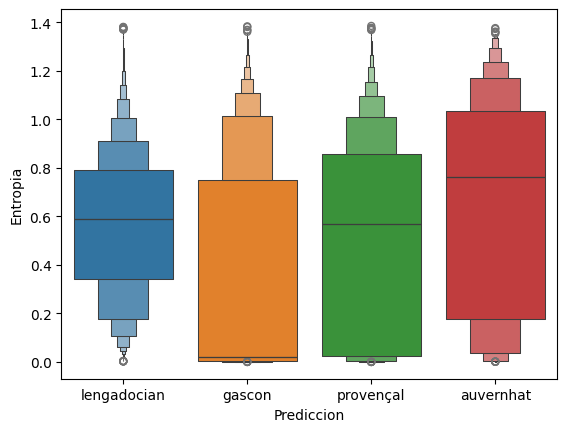

In [15]:
sns.boxenplot(data=resultats_df, x="Prediccion", y="Entropia", hue="Prediccion")

In [16]:
resultats_df.query('Dialecte.isnull() & Prediccion == "lengadocian"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
72540,Colador,lengadocian,1.380762,0.234537,0.226925,0.295174,0.243364,NaN
48366,La_Comunautat_de_l'Anèl,lengadocian,1.378952,0.228449,0.245463,0.301612,0.224476,NaN
4088,Wiltshire,lengadocian,1.376538,0.224152,0.283254,0.285281,0.207312,NaN
4949,Patronim,lengadocian,1.373885,0.263720,0.188536,0.294568,0.253175,NaN
46621,Actinopodidae,lengadocian,1.372962,0.256810,0.243276,0.307036,0.192879,NaN
62858,Vaux-Andigny,lengadocian,1.370307,0.258066,0.247911,0.309176,0.184847,NaN
26937,Loís_I_de_Portugal,lengadocian,1.369690,0.199563,0.281207,0.307542,0.211688,NaN
3153,Sent_Ferriòu,lengadocian,1.369185,0.273510,0.198315,0.314033,0.214142,NaN
49653,Roseda_(mètro_de_Tolosa),lengadocian,1.369000,0.172685,0.274648,0.278279,0.274387,NaN
66097,Dusty_Springfield,lengadocian,1.365566,0.284231,0.183041,0.311075,0.221653,NaN


In [17]:
resultats_df.query('Dialecte.isnull() & Prediccion == "auvernhat"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
37979,Rabastens,auvernhat,1.375841,0.292923,0.198785,0.236336,0.271956,NaN
20824,Saint-Vitte,auvernhat,1.372221,0.309712,0.226413,0.198067,0.265807,NaN
71015,Tauçac,auvernhat,1.361299,0.308093,0.302444,0.186729,0.202734,NaN
8968,La_Ròca_(Val_d'Estura),auvernhat,1.358577,0.303260,0.165709,0.228002,0.303029,NaN
20769,Lafauche,auvernhat,1.358319,0.337243,0.171367,0.237454,0.253935,NaN
10162,Swazi,auvernhat,1.353200,0.345016,0.203936,0.272742,0.178305,NaN
13522,Elfriede_Jelinek,auvernhat,1.352651,0.349182,0.264610,0.211065,0.175143,NaN
70807,Streptococcus,auvernhat,1.351828,0.322254,0.149542,0.252444,0.275760,NaN
41483,Brotomys,auvernhat,1.350209,0.325000,0.267747,0.146903,0.260349,NaN
3101,Províncias_d'Itàlia,auvernhat,1.348939,0.326903,0.234053,0.150329,0.288715,NaN


In [18]:
texte_etiquetas_df.groupby("Dialecte")["Article"].count()

Dialecte
auvernhat       512
gascon         2847
lengadocian     157
provençal      4778
Name: Article, dtype: int64

In [19]:
resultats_df.groupby("Prediccion")["Article"].count()

Prediccion
auvernhat       1304
gascon          9544
lengadocian    50187
provençal      20573
Name: Article, dtype: int64

In [20]:
# explicador = shap.TreeExplainer(xgb_final)
# shap_df = pd.DataFrame(explicador(bow_test), index=texte_etiquetas_test["Article"], columns=vocab_list)

In [21]:
vocab = {v: k for k, v in vectorizador.vocabulary_.items()}
vocab_list = [vocab[i] for i in range(len(vocab))]

fi_df = pd.DataFrame({"FI": xgb_final.feature_importances_})
fi_df["TokenIndex"] = list(range(0, fi_df.shape[0]))
fi_df["Token"] = fi_df["TokenIndex"].map(lambda x: vocab[x])
fi_df.sort_values("FI", ascending=False).head(60)

,FI,TokenIndex,Token
17248,0.087875,17248,ġua
9674,0.058912,9674,ġdei
2188,0.033464,2188,es
561,0.032861,561,alfabet
9578,0.026005,9578,ġdau
9947,0.022601,9947,ġdeu
9696,0.019760,9696,ġdels
16096,0.017651,16096,ġsantiago
12860,0.016406,12860,ġloire
12792,0.016360,12792,ġlingã¼istica
